Getting a bit into the world of mathematical finance, we will tackle the Black-Scholes model and the associated Black-Scholes PDE.

The unnderying theory of the model is this: Assuming you are holding 1 stock in which its value (or payoff) can be measured as a function $V(S,t)$ where $S$ is the stock-price and $t$ is the time then further assume that the stock price follows or evolves as the [Geometric Brownian Motion](https://en.wikipedia.org/wiki/Geometric_Brownian_motion), sometimes known as the exponential return process
$$
    dS = \mu S dt + \sigma S dW
$$.
The $\mu$ parameter is called the drift or the expected returns while the $\sigma$ is the volatility parameter which is the fluctuations in the returns and $W_t$ is a Wierner process $dW_t \sim \mathcal{N}(0,1)$ then using the [It&ocirc; lemma](https://en.wikipedia.org/wiki/It%C3%B4%27s_lemma) we can compute the stochastic differential $dV$ as
$$\begin{align*}
	dV = \left(\frac{\partial V}{\partial t} + \mu S\frac{\partial V}{\partial S} + \frac{(\sigma S)^2}{2}\right)dt + \sigma S\frac{\partial V}{\partial S}dW
\end{align*}$$


and the concept of self-financing portfolio we can introduce a risk-free rate $r$ and eliminate the risk (that is, the $dW$ term) to arrive at the infamous PDE
$$\begin{align*}
	\frac{\partial V}{\partial t}+ \frac{\sigma^2 S^2}{2} + rS\frac{\partial V}{\partial S} - rV= 0
\end{align*}$$

see this [video](https://www.youtube.com/watch?v=A5w-dEgIU1M) for more contexts.

We will try to develop a PINN that can solve the European call option for this PDE which is a **terminal condition** problem where instead of knowing the initial condtion, and solving for the final state, we do the opposite. We are given a strike price $K$ and the final payoff function $V(S,T) = \max()$ at the time of maturity $t=T$ and our job is to go back in time to solve for the initial condition.

Classically, one would do the variable change $\tau = T-t$ and $x = \ln\left(\frac{S}{K}\right)$ to transform the problem into the standard forward heat equation which gives the closed-form solution
$$\begin{align*}
    V_{analytical}(S,t) = S\Phi(d_+) - Ke^{-r(T-t)}\Phi(d_-)
\end{align*}$$
where $\Phi(z)$ is the cummulative distribution function (CDF) of the standard normal distribution and
$$\begin{align*}
    d_+ = \frac{1}{\sigma\sqrt{T-t}} \left( \ln\left(\frac{S}{K}\right) + t\left(\frac{r + \frac{\sigma^2}{2}}{2}\right) \right) \qquad \text{with} \qquad d_- = d_+ - \sigma\sqrt{t}
\end{align*}$$

So in this notebook, we will develop a Neural Network that can solve the European call option for the Black-Scholes PDE which posed on the price-time domain $(S,t) \in [S_{min}, \infty] \times [0,T]$.  Do note that $\mu, \sigma, r$ are given parameters to the PDE. In practice, one would need to derive them from calibrating market data, but here, we can hard-code them to create a model and benchmark. Of course, the above analytical solution is imposed upon the condition
$$\begin{align*}
    & V(S,T) = \max(S-K, 0) \\
    & \lim_{S \to \infty} V(S,t) = S - Ke^{-r(T-t)} \\
    & V(S_{min}, t) = 0
\end{align*}$$


**Remark**: One of the nice thing about PINNs and Neural Networks in general is that not only that they are a statistical model, but they are also continuous approximator meaning that compare to classical numerical methods, you don't need to make special treatment as how you handle time (i.e. no time-stepping), you will treat time-direction exactly similar to how you would treat spatial dimensions and if you are able to work this model out, it will become evident to you.

**Implementation**<br><br>To develop a NN that can solve the EU Call Option for BS PDE as mentioned, we need to import the necessary libraries. Afterwards, we will create a function for the BS EU Call Option + placeholder parameter values.

In [1]:
%pip install torch numpy matplotlib scipy

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("PyTorch version:", torch.__version__)
print("Device:", "cuda" if torch.cuda.is_available() else "cpu")

PyTorch version: 2.8.0+cu126
Device: cpu


In [12]:
K = 100.0 # Strike price
T = 1.0 # Time to maturity, expressed in years
r = 0.05 # Risk-free rate
sigma = 0.2 # Volatility
S_min = 0.0 # Minimum stock price
S_max = 200.0 # Maximum stock price
t = 0 # Current time (0 = time today)

def black_scholes_call(S, t, K, T, r, sigma):
    tau = T - t
    # Handle terminal condition using np.where for element-wise comparison
    if isinstance(tau, np.ndarray):
        # For array inputs, calculate call price where tau > 0, otherwise use max(S-K, 0)
        d_plus = (np.log(S / K) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))
        d_minus = d_plus - sigma * np.sqrt(tau)
        call_price = np.where(tau > 0, S * norm.cdf(d_plus) - K * np.exp(-r * tau) * norm.cdf(d_minus), np.maximum(S - K, 0))
    else:
        # For scalar inputs, use original logic
        if tau <= 0:
            return np.maximum(S - K, 0)
        d_plus = (np.log(S / K) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))
        d_minus = d_plus - sigma * np.sqrt(tau)
        call_price = S * norm.cdf(d_plus) - K * np.exp(-r * tau) * norm.cdf(d_minus)

    return call_price

print(f"Parameters: K={K}, T={T}, r={r}, sigma={sigma}")

Parameters: K=100.0, T=1.0, r=0.05, sigma=0.2


In [13]:
class BlackScholesPINN(nn.Module):
    # set suitable hidden layers + neurons -> prevent over and underfitting
    def __init__(self, hidden_layers=3, neurons=32):
        super(BlackScholesPINN, self).__init__()

        # Build the network: input (S, t) -> output V
        layers = []
        layers.append(nn.Linear(2, neurons))
        layers.append(nn.Tanh())

        for _ in range(hidden_layers - 1):
            layers.append(nn.Linear(neurons, neurons))
            layers.append(nn.Tanh())

        layers.append(nn.Linear(neurons, 1))

        self.network = nn.Sequential(*layers)

    def forward(self, S, t):
        """
        Forward pass: predict option value V(S, t)
        S: stock price tensor
        t: time tensor
        """
        x = torch.cat([S, t], dim=1)
        V = self.network(x)
        return V

model = BlackScholesPINN(hidden_layers=4, neurons=32)
print(f"Model created with {sum(p.numel() for p in model.parameters())} parameters")

Model created with 3297 parameters


In the cell above, we define the architecture for our Physics-Informed Neural Network (PINN) that will be used to approximate the solution to the Black-Scholes PDE. The model is built using PyTorch and consists of several fully connected layers (also called hidden layers), each with a specified number of neurons and activation functions (here, Tanh). The input to the network is a pair of values: stock price ($S$) and time ($t$), and the output is the predicted option value:

$$
V(S, t) \approx \mathcal{N}(S, t; \theta)
$$
where $\mathcal{N}$ is the neural network with parameters $\theta$ (weights and biases), and $V(S, t)$ is the model's output for given inputs $S$ and $t$.

In [17]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # Learning rate

# PDE residual computation using automatic differentiation
def compute_pde_residual(model, S, t, r, sigma):
    S.requires_grad_(True)
    t.requires_grad_(True)

    V = model(S, t)

    # First derivatives
    V_t = torch.autograd.grad(V.sum(), t, create_graph=True)[0]
    V_S = torch.autograd.grad(V.sum(), S, create_graph=True)[0]

    # Second derivative with respect to S
    V_SS = torch.autograd.grad(V_S.sum(), S, create_graph=True)[0]

    # Black-Scholes PDE: ∂V/∂t + (σ²S²/2)∂²V/∂S² + rS∂V/∂S - rV = 0
    pde_residual = V_t + 0.5 * sigma**2 * S**2 * V_SS + r * S * V_S - r * V

    return pde_residual

def generate_training_data(n_pde=900, n_boundary=100): # Controlling training points
    # PDE collocation points
    S_pde = torch.rand(n_pde, 1) * (S_max - S_min) + S_min
    t_pde = torch.rand(n_pde, 1) * T

    # Terminal condition: V(S, T) = max(S - K, 0)
    S_terminal = torch.rand(n_boundary, 1) * (S_max - S_min) + S_min
    t_terminal = torch.ones(n_boundary, 1) * T
    V_terminal = torch.maximum(S_terminal - K, torch.zeros_like(S_terminal))

    # Lower boundary: V(S_min, t) = 0
    S_lower = torch.ones(n_boundary, 1) * S_min
    t_lower = torch.rand(n_boundary, 1) * T
    V_lower = torch.zeros(n_boundary, 1)

    # Upper boundary: V(S_max, t) ≈ S_max - K*exp(-r(T-t))
    S_upper = torch.ones(n_boundary, 1) * S_max
    t_upper = torch.rand(n_boundary, 1) * T
    V_upper = S_upper - K * torch.exp(-r * (T - t_upper))

    return (S_pde, t_pde), (S_terminal, t_terminal, V_terminal), \
           (S_lower, t_lower, V_lower), (S_upper, t_upper, V_upper)

After setting up the PDE residual function in the previous cell, if our network predicts $V(S, t)$ perfectly, this equation will be close to zero everywhere.

Epoch 200/5000, Loss: 57.870716, PDE: 14.754412, Terminal: 0.540326
Epoch 400/5000, Loss: 18.860191, PDE: 8.388451, Terminal: 0.434336
Epoch 600/5000, Loss: 8.733434, PDE: 3.022108, Terminal: 0.370505
Epoch 800/5000, Loss: 8.648363, PDE: 3.839206, Terminal: 0.322488
Epoch 1000/5000, Loss: 97.435959, PDE: 0.881433, Terminal: 2.124450
Epoch 1200/5000, Loss: 3.952547, PDE: 1.109525, Terminal: 0.259133
Epoch 1400/5000, Loss: 10.209950, PDE: 5.747941, Terminal: 0.259597
Epoch 1600/5000, Loss: 3.976884, PDE: 1.455934, Terminal: 0.225665
Epoch 1800/5000, Loss: 26.638411, PDE: 2.054380, Terminal: 0.871914
Epoch 2000/5000, Loss: 2.934851, PDE: 0.855912, Terminal: 0.194497
Epoch 2200/5000, Loss: 2.702003, PDE: 0.803947, Terminal: 0.180302
Epoch 2400/5000, Loss: 2.672564, PDE: 0.835020, Terminal: 0.174027
Epoch 2600/5000, Loss: 3.047120, PDE: 1.090633, Terminal: 0.171988
Epoch 2800/5000, Loss: 177.483978, PDE: 13.776853, Terminal: 5.504133
Epoch 3000/5000, Loss: 6.757041, PDE: 2.603421, Terminal:

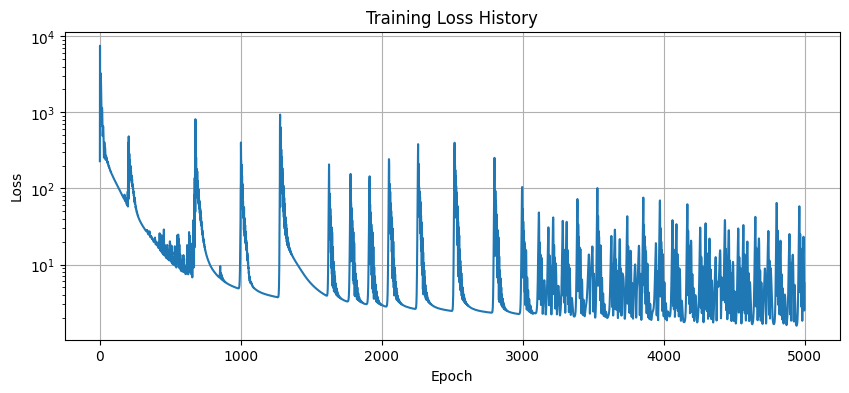

In [18]:
# Training loop
epochs = 5000 # dont train too much -> overfitting
loss_history = []

pde_data, terminal_data, lower_data, upper_data = generate_training_data(n_pde=2000, n_boundary=200)

for epoch in range(epochs):
    optimizer.zero_grad()

    # PDE loss
    S_pde, t_pde = pde_data
    pde_residual = compute_pde_residual(model, S_pde, t_pde, r, sigma)
    loss_pde = torch.mean(pde_residual**2)

    # Terminal condition loss
    S_term, t_term, V_term = terminal_data
    V_pred_term = model(S_term, t_term)
    loss_terminal = torch.mean((V_pred_term - V_term)**2)

    # Lower boundary loss
    S_low, t_low, V_low = lower_data
    V_pred_low = model(S_low, t_low)
    loss_lower = torch.mean((V_pred_low - V_low)**2)

    # Upper boundary loss
    S_up, t_up, V_up = upper_data
    V_pred_up = model(S_up, t_up)
    loss_upper = torch.mean((V_pred_up - V_up)**2)

    # Total loss (weighted sum)
    loss = loss_pde + 10 * loss_terminal + 10 * loss_lower + 10 * loss_upper

    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())

    if (epoch + 1) % 200 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}, "
              f"PDE: {loss_pde.item():.6f}, Terminal: {loss_terminal.item():.6f}")

# Plot training loss
plt.figure(figsize=(10, 4))
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss History')
plt.yscale('log')
plt.grid(True)
plt.show()

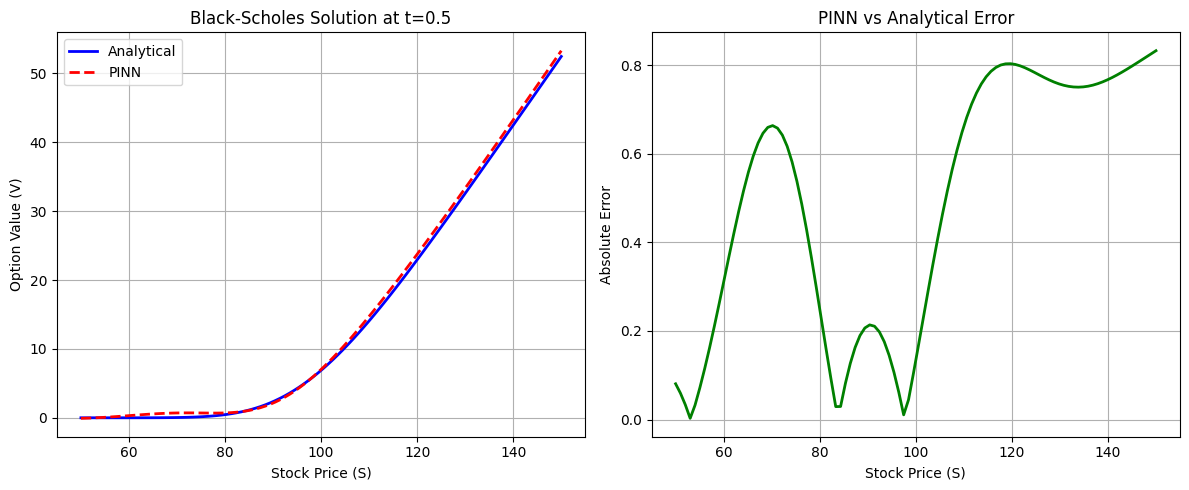

Mean Absolute Error: 0.493244


In [19]:
# Compare PINN solution with analytical solution
model.eval()

# Create test grid
S_test = np.linspace(50, 150, 100)
t_test = 0.5  # Test at t = 0.5

# PINN prediction
S_tensor = torch.tensor(S_test.reshape(-1, 1), dtype=torch.float32)
t_tensor = torch.full((len(S_test), 1), t_test, dtype=torch.float32)
with torch.no_grad():
    V_pinn = model(S_tensor, t_tensor).numpy().flatten()

# Analytical solution
V_analytical = black_scholes_call(S_test, t_test, K, T, r, sigma)

# Plot comparison
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(S_test, V_analytical, 'b-', label='Analytical', linewidth=2)
plt.plot(S_test, V_pinn, 'r--', label='PINN', linewidth=2)
plt.xlabel('Stock Price (S)')
plt.ylabel('Option Value (V)')
plt.title(f'Black-Scholes Solution at t={t_test}')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(S_test, np.abs(V_analytical - V_pinn), 'g-', linewidth=2)
plt.xlabel('Stock Price (S)')
plt.ylabel('Absolute Error')
plt.title('PINN vs Analytical Error')
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"Mean Absolute Error: {np.mean(np.abs(V_analytical - V_pinn)):.6f}")

The image above shows our PINN model solving the Black-Scholes PDE for an EU option halfway to expiration (t=0.5). <br><br>The left plot demonstrates that the neural network (red dashed) closely matches the analytical solution (blue solid) across stock prices from 50-150, and the right plot reveals the PINN's accuracy issues through absolute error, showing oscillating errors with peaks around 0.8-0.9 the further away S is from K, while achieving near-perfect accuracy just near K(~97).<br><br> From the general looks of things, despite having an MVP and our PINN being fairly decent as is, there's still room for improvement.

/tmp/ipython-input-1233043709.py:14: RuntimeWarning: divide by zero encountered in divide
  d_plus = (np.log(S / K) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))


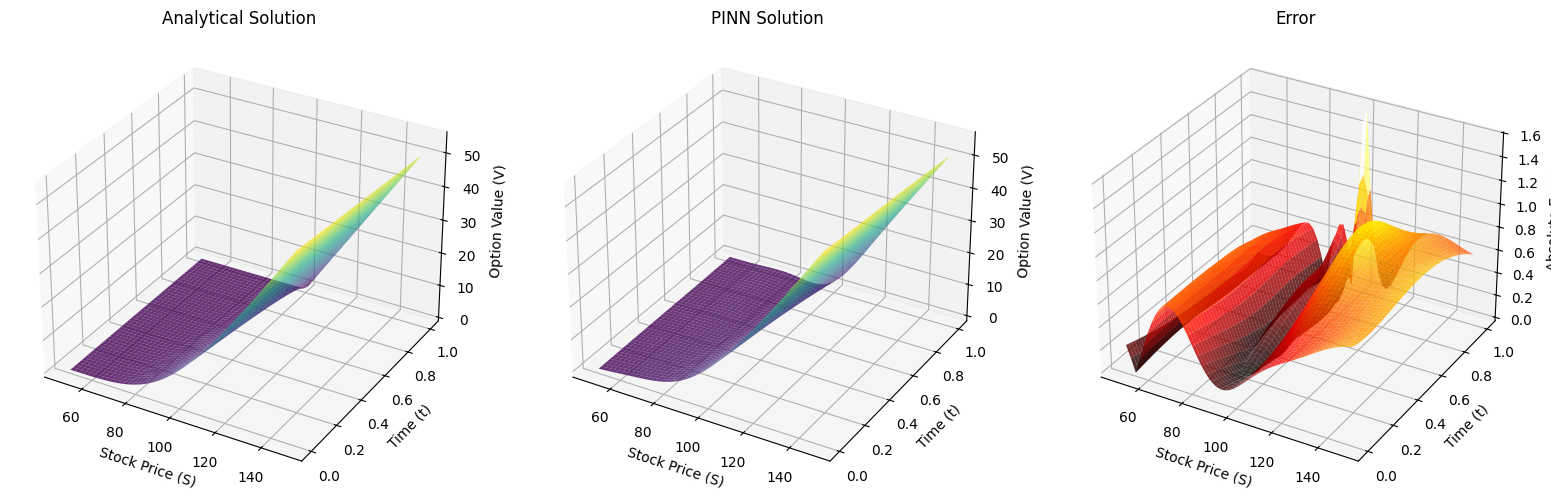

Max Error: 1.575821
Mean Error: 0.463429


In [20]:
# 2D Visualization: Option surface over (S, t) domain
S_grid = np.linspace(50, 150, 50)
t_grid = np.linspace(0, T, 50)
S_mesh, t_mesh = np.meshgrid(S_grid, t_grid)

# PINN predictions
S_flat = torch.tensor(S_mesh.flatten().reshape(-1, 1), dtype=torch.float32)
t_flat = torch.tensor(t_mesh.flatten().reshape(-1, 1), dtype=torch.float32)
with torch.no_grad():
    V_pinn_surface = model(S_flat, t_flat).numpy().reshape(S_mesh.shape)

# Analytical solution
V_analytical_surface = black_scholes_call(S_mesh, t_mesh, K, T, r, sigma)

# Plot surface comparison
fig = plt.figure(figsize=(16, 5))

ax1 = fig.add_subplot(131, projection='3d')
ax1.plot_surface(S_mesh, t_mesh, V_analytical_surface, cmap='viridis', alpha=0.8)
ax1.set_xlabel('Stock Price (S)')
ax1.set_ylabel('Time (t)')
ax1.set_zlabel('Option Value (V)')
ax1.set_title('Analytical Solution')

ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_surface(S_mesh, t_mesh, V_pinn_surface, cmap='viridis', alpha=0.8)
ax2.set_xlabel('Stock Price (S)')
ax2.set_ylabel('Time (t)')
ax2.set_zlabel('Option Value (V)')
ax2.set_title('PINN Solution')

ax3 = fig.add_subplot(133, projection='3d')
error_surface = np.abs(V_analytical_surface - V_pinn_surface)
ax3.plot_surface(S_mesh, t_mesh, error_surface, cmap='hot', alpha=0.8)
ax3.set_xlabel('Stock Price (S)')
ax3.set_ylabel('Time (t)')
ax3.set_zlabel('Absolute Error')
ax3.set_title('Error')

plt.tight_layout()
plt.show()

print(f"Max Error: {np.max(error_surface):.6f}")
print(f"Mean Error: {np.mean(error_surface):.6f}")

**Next Steps**: Can we fine tune and hyper-parameterize our model to minimize the error?